# Phase 2: Simulation-Based Data Generation for LIF Model (BayesFlow-Ready)

---

## 1. Introduction

**Goal:**  
Generate a large, diverse set of LIF neuron simulations with varied parameters, in a way that is fully compatible with simulation-based inference (SBI) using BayesFlow.

- No pre-saving, normalization, or splitting of datasets is needed.
- Instead, we define a **prior** and a **simulator** function, which BayesFlow will use to generate data on-the-fly during training.

---

## 2. Parameter Ranges

We sample all key LIF parameters from biologically plausible ranges to ensure diversity and improve generalization:

- **τₘ (ms):** 5.0 – 30.0  
- **E_L (mV):** –80.0 – –65.0  
- **g_L (nS):** 5.0 – 15.0  
- **V_th (mV):** –60.0 – –50.0  
- **V_reset (mV):** –80.0 – –65.0  
- **I (pA):** 50.0 – 300.0  

---

## 2.1. SBI/BayesFlow: The Role of Prior and Simulator

In simulation-based inference (SBI) with BayesFlow, we do **not** need to pre-generate and save a large dataset. Instead, we provide two key ingredients:

- **Prior:** A function that samples plausible parameters (from the ranges above).
- **Simulator:** A function that, given a set of parameters, returns a simulated voltage trace.

BayesFlow will call these functions on-the-fly during training, ensuring that the neural network sees fresh, diverse data at every step. This approach is more flexible and avoids issues with dataset size, normalization, and splitting.

---

### Why Not Use Pre-Saved Datasets?
- **No normalization needed:** BayesFlow learns directly from the raw simulator outputs.
- **No splitting needed:** Training and validation are handled by the BayesFlow trainer.
- **No risk of overfitting to a fixed dataset:** The network always sees new samples.

---

## 2.2. BayesFlow-Ready Prior and Simulator

Below, we define the prior and simulator functions in a way that is fully compatible with BayesFlow. These will be used directly in Phase 4 for neural posterior training.

---

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
from scipy.stats import uniform
from src.lif_model import lif_simulate  # Your LIF simulation function

# Define parameter ranges (same as above)
PARAM_BOUNDS = {
    'tau_m':   (5.0, 30.0),    # ms
    'E_L':     (-80.0, -65.0), # mV
    'g_L':     (5.0, 15.0),    # nS
    'V_th':    (-60.0, -50.0), # mV
    'V_reset': (-80.0, -65.0), # mV
    'I':       (50.0, 300.0),  # pA
}
PARAM_KEYS = list(PARAM_BOUNDS.keys())
N_PARAMS = len(PARAM_KEYS)

# Prior: samples parameters from uniform distributions
def prior(batch_size):
    """
    Samples parameters from uniform priors for each parameter.
    Returns: np.ndarray of shape (batch_size, n_params)
    """
    samples = []
    for key in PARAM_KEYS:
        low, high = PARAM_BOUNDS[key]
        samples.append(uniform.rvs(loc=low, scale=high-low, size=batch_size))
    return np.stack(samples, axis=1)

# Simulator: generates a voltage trace for each parameter set
def simulator(params, T=200.0, dt=0.1, tref=2.0, noise_std=0.5):
    """
    params: np.ndarray of shape (batch_size, n_params)
    Returns: np.ndarray of simulated voltage traces (batch_size, trace_length)
    """
    traces = []
    for p in params:
        param_dict = dict(zip(PARAM_KEYS, p))
        sim_args = {
            'T': T,
            'dt': dt,
            'E_L': param_dict['E_L'],
            'V_th': param_dict['V_th'],
            'V_reset': param_dict['V_reset'],
            'tau_m': param_dict['tau_m'],
            'g_L': param_dict['g_L'],
            'I': param_dict['I'],
            'tref': tref
        }
        t, V, spikes = lif_simulate(**sim_args)
        V_noisy = V + np.random.normal(0, noise_std, size=V.shape)
        traces.append(V_noisy)
    return np.stack(traces, axis=0)

# Example usage:
# params = prior(4)
# traces = simulator(params)
# print(traces.shape)  # (4, trace_length)

## 3. Visualize Example Traces

Let's visualize a few simulated traces to check the diversity and realism of the generated data.

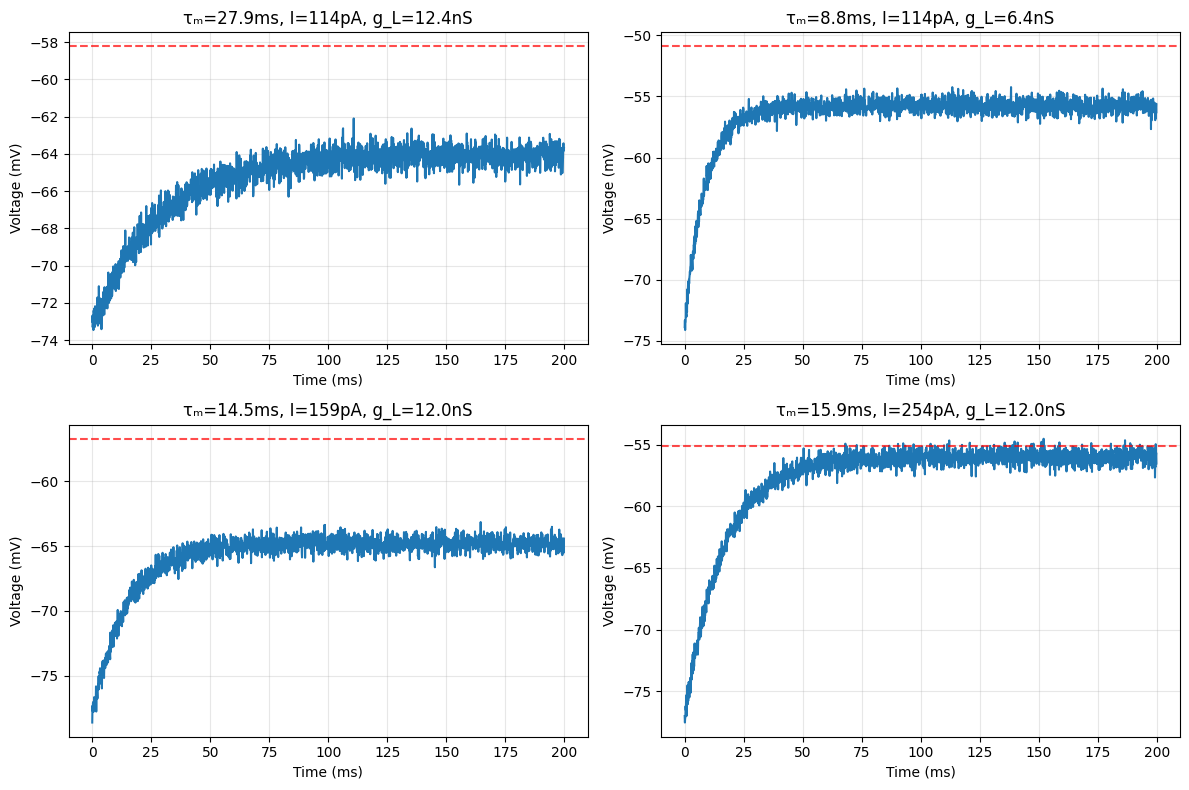

In [2]:
import matplotlib.pyplot as plt

# Generate and plot 4 random traces
params = prior(4)
traces = simulator(params)
t_plot = np.arange(0, traces.shape[1]) * 0.1  # dt=0.1 ms

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i in range(4):
    tau_m, E_L, g_L, V_th, V_reset, I = params[i]
    axes[i].plot(t_plot, traces[i])
    axes[i].axhline(V_th, color='r', linestyle='--', alpha=0.7)
    axes[i].set_title(f'τₘ={tau_m:.1f}ms, I={I:.0f}pA, g_L={g_L:.1f}nS')
    axes[i].set_xlabel('Time (ms)')
    axes[i].set_ylabel('Voltage (mV)')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Example Trace Visualization — Explanation

- **Parameter Diversity:** Each subplot title shows the sampled values for τₘ, I, and g_L, demonstrating the diversity in the dataset.
- **Threshold Visualization:** The red dashed line marks the spike threshold (V_th) for each neuron.
- **Behavioral Variety:** Some traces show regular spiking, others remain subthreshold, reflecting the range of possible neuron behaviors.
- **Noise Augmentation:** Traces include added Gaussian noise, making the data more realistic and helping neural networks generalize.

**Why this is good:**
- The simulation produces both spiking and non-spiking behavior.
- The parameter sampling covers a wide range of neuron dynamics.
- The traces look biologically plausible and are ready for use in SBI/BayesFlow.

## 4. Summary & Next Steps

- You now have BayesFlow-ready **prior** and **simulator** functions for the LIF neuron model.
- No dataset saving, normalization, or splitting is needed.
- Proceed to Phase 3: using these functions for training and inference with BayesFlow.

---